In [1]:
from google.colab import drive
 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install transformers

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AdamW, get_linear_schedule_with_warmup
import re 
import numpy as np 
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models
from sklearn.metrics import classification_report
from collections import Counter
from collections import defaultdict
from gensim.models import KeyedVectors

In [4]:
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0


df_train = pd.read_csv("./gdrive/MyDrive/Models/train_processed.tsv", sep='\t')
df_train = df_train[['tweet_text', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['tweet_text'] = df_train['tweet_text'].apply(clean_text)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)



df_val = pd.read_csv("./gdrive/MyDrive/Models/val_processed.tsv", sep='\t')
df_val = df_val[['tweet_text', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['tweet_text'] = df_val['tweet_text'].apply(clean_text)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/Models/test_processed.tsv", sep='\t')
df_test = df_test[['tweet_text', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['tweet_text'] = df_test['tweet_text'].apply(clean_text)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)

In [5]:
weights = KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/crisisNLP_word2vec_model/crisisNLP_word_vector.bin', binary=True)
weights = torch.FloatTensor(weights.vectors)

In [6]:
class DisasterTweetDataset(Dataset):

  def __init__(self, tweets, targets):
    self.tweets = tweets
    self.targets = targets  
  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = self.tweets[item]
    target = self.targets[item]

    tweet = tweet.split()
    tweet = list(map(int, tweet))

    return {
      'input_ids': torch.tensor(tweet),
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, batch_size):
  ds = DisasterTweetDataset(
    tweets=df.tweet_text.to_numpy(),
    targets=df.label_text.to_numpy()
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [7]:
class kimCNN(nn.Module):
    """
    The embedding layer + CNN model that will be used to perform analysis.
    """

    def __init__(self, weights, vocab_size, output_size, embedding_dim, num_filters=100, kernel_sizes=[3, 4, 5], freeze_embeddings=True):
        """
        Initialize the model by setting up the layers.
        """
        super(kimCNN, self).__init__()

        # set class vars
        self.num_filters = num_filters
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding.from_pretrained(weights)
        print(self.embedding)
        
        if freeze_embeddings:
            self.embedding.requires_grad = False
        
        
        self.y = nn.Conv2d(1,300, (4, embedding_dim))
        self.y_relu = nn.ReLU()
        self.y_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 4 + 1, 1))


        self.z = nn.Conv2d(1,300, (3, embedding_dim))
        self.z_relu = nn.ReLU()
        self.z_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 3 + 1, 1))

        self.z1 = nn.Conv2d(1,300, (2, embedding_dim))
        self.z1_relu = nn.ReLU()
        self.z1_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 2 + 1, 1))

        self.w1 = nn.Conv2d(1,300, (1, embedding_dim))
        self.w1_relu = nn.ReLU()
        self.w1_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 1 + 1, 1))


        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.02)
        self.fc_1 = nn.Linear(1200, 100)
        self.relu_2 = nn.ReLU()
        self.fc_2 = nn.Linear(100, 50)
        self.relu_3 = nn.ReLU()
        self.fc_3 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        """
        Defines how a batch of inputs, x, passes through the model layers.
        Returns a single, sigmoid-activated class score as output.
        """

        # embedded vectors
        embeds = self.embedding(x) # (batch_size, seq_length, embedding_dim)
        # embeds.unsqueeze(1) creates a channel dimension that conv layers expect
        embeds = embeds.unsqueeze(1)

        y_out = self.y(embeds)
        y_relu_out = self.y_relu(y_out)
        y_pool_out = self.y_pool(y_relu_out)

        z_out = self.z(embeds)
        z_relu_out = self.z_relu(z_out)
        z_pool_out = self.z_pool(z_relu_out)

        z1_out = self.z1(embeds)
        z1_relu_out = self.z1_relu(z1_out)
        z1_pool_out = self.z1_pool(z1_relu_out)

        w1_out = self.w1(embeds)
        w1_relu_out = self.w1_relu(w1_out)
        w1_pool_out = self.w1_pool(w1_relu_out)

        merged_output = torch.cat((y_pool_out, z_pool_out, z1_pool_out, w1_pool_out), dim=1)
        merged_output = torch.squeeze(merged_output,3)
        merged_output = torch.squeeze(merged_output,2)
        #print(merged_output.size())

        relu1_out = self.relu_1(merged_output)

        dropout1_out = self.dropout_1(relu1_out)
        fc1_out = self.fc_1(dropout1_out)
        
        relu2_out = self.relu_2(fc1_out)
        fc2_out = self.fc_2(relu2_out)

        relu3_out = self.relu_3(fc2_out)
        fc3_out = self.fc_3(relu3_out)

        probas = self.sigmoid(fc3_out)

        return probas


In [8]:
# Instantiate the model w/ hyperparams

vocab_size = 2152854 #len(pretrained_words)
output_size = 1 # binary class (1 or 0)
embedding_dim = 300 #len(embed_lookup[pretrained_words[0]])
num_filters = 512
kernel_sizes = [2, 3, 4]
MAX_SEQUENCE_LENGTH = 25

batch_size = 128
EPOCHS = 300

train_data_loader = create_data_loader(df_train, batch_size)
val_data_loader = create_data_loader(df_val, batch_size)
test_data_loader = create_data_loader(df_test, batch_size)

model = kimCNN(weights, vocab_size, output_size, embedding_dim, num_filters, kernel_sizes)
model = model.to(device)

lr=0.00001
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, min_lr=0, verbose=False)

Embedding(2152854, 300)


In [9]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(x=input_ids)


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(x=input_ids)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Epoch 1/300
----------
Train loss 0.6699074726355704 accuracy 0.6608686595146339
Val   loss 0.6588621414624728 accuracy 0.6713286713286714

Epoch 2/300
----------
Train loss 0.6554013318137119 accuracy 0.6608686595146339
Val   loss 0.6424580904153677 accuracy 0.6713286713286714

Epoch 3/300
----------
Train loss 0.6400482191851264 accuracy 0.6608686595146339
Val   loss 0.6261463394531837 accuracy 0.6713286713286714

Epoch 4/300
----------
Train loss 0.6264428637529674 accuracy 0.6608686595146339
Val   loss 0.6134198445540208 accuracy 0.6713286713286714

Epoch 5/300
----------
Train loss 0.6163939496404246 accuracy 0.6608686595146339
Val   loss 0.6045880409387442 accuracy 0.6713286713286714

Epoch 6/300
----------
Train loss 0.6090343037718221 accuracy 0.6608686595146339
Val   loss 0.5979245396760794 accuracy 0.6713286713286714

Epoch 7/300
----------
Train loss 0.6022653760094392 accuracy 0.6608686595146339
Val   loss 0.5912424142544086 accuracy 0.6713286713286714

Epoch 8/300
--------

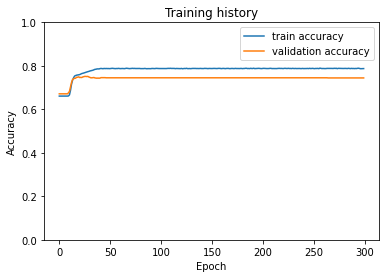

In [10]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/FYP/Models/bert-checkpoint-40.t7", map_location=torch.device('cpu'))
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']

# print(start_epoch)


for epoch in range(EPOCHS):

  print(f'Epoch {start_epoch + epoch + 1}/{start_epoch + EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  scheduler.step(val_acc)
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/Models/KimCNN/checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/KimCNN/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/KimCNN/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

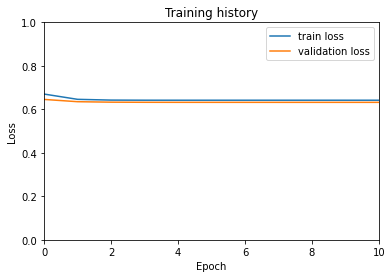

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [11]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        x=input_ids,
      )
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative'], digits = 4))

                 precision    recall  f1-score   support

Not Informative     0.7091    0.4643    0.5612       504
    Informative     0.7757    0.9068    0.8362      1030

       accuracy                         0.7614      1534
      macro avg     0.7424    0.6855    0.6987      1534
   weighted avg     0.7538    0.7614    0.7458      1534

